In [1]:
using CairoMakie;
using DelimitedFiles, Statistics, Glob, LaTeXStrings, StatsBase, LinearAlgebra, SparseArrays, Distances, LazySets, PolynomialRoots, FastGaussQuadrature;
using Measures: mm

include("final_analysis_library.jl");

In [ ]:
#simulation params
L = 8
M = 100
B = 1;
nu = 0.005;
Delta = 4.;
F0 = 1.; 

K = 4
pk = 0.2

ncopies = 100
tini = 75
nsteps = 200
dt = 50

N = 128 
folder = "../data/Delta$(Delta)_F0$(F0)_nu$(nu)_N$(N)_M$(M)_B$(B)_L$(L)/half_fixed/long_K$(K)_pk$(pk)/";

sfolder = folder*"zeros/sample_1/"
fieldmatrix = readdlm(sfolder*"fieldmatrix.txt",header=true)[1][:,2:end];

means = mean(fieldmatrix,dims=1)
dh = fieldmatrix .- means
cij = (dh' * dh)/M
F,V,G = get_FVG(means,cij,L,K)
vars = var(fieldmatrix,dims=1)

t = map(F, V) do xi, yi
           [xi, yi]
    end;
ch = convex_hull(t)
C = reduce(hcat,ch);

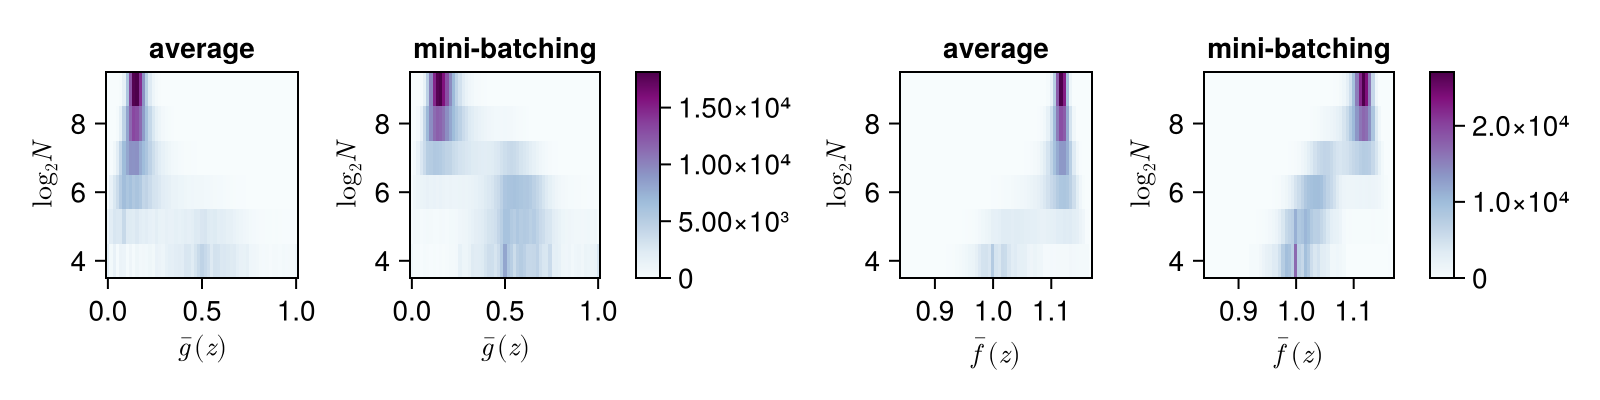

In [3]:
pref = "../data/persistent/Delta$(Delta)_F0$(F0)_nu$(nu)_"
postf = "_M100_B1_L$(L)_pers0.0/half_fixed/long_K$(K)_pk$(pk)/"
Narr = 2 .^range(4,9)
lN = length(Narr);

nbins = 60

fmin = 0.84
fmax = 1.17

Gdist =  []
GRdist = []
Fdist = []
FRdist = []
j=1
inits = ["zeros/","ones/","rand1/","rand2/","rand3/","rand4/","rand5/"]
for N in Narr
    folder = pref*"N$(N)"*postf
    ghist = []
    gr_hist = []
    fhist = []
    fr_hist = []
    for init_cond in inits
        favg,gavg,fref,gref,fdist,gdist,fr_dist,gr_dist = get_means_distr(folder*init_cond, ncopies, tini)
        append!(ghist,gdist./N)
        append!(gr_hist,gr_dist./N)
        append!(fhist,fdist./N)
        append!(fr_hist,fr_dist./N)
    end
    push!(Gdist,fit(Histogram, ghist, range(-0.01,1.01,nbins)).weights)
    push!(GRdist,fit(Histogram, gr_hist, range(-0.01,1.01,nbins)).weights)
    push!(Fdist,fit(Histogram, fhist, range(fmin,fmax,nbins)).weights)
    push!(FRdist,fit(Histogram, fr_hist, range(fmin,fmax,nbins)).weights)
    j+=1
end

Gdist = reduce(hcat,Gdist)  
GRdist = reduce(hcat,GRdist)
Fdist = reduce(hcat,Fdist)
FRdist = reduce(hcat,FRdist)

edges = range(-0.01,1.01,nbins)
edges_f = range(fmin,fmax,nbins)
f = Figure(size=(800,200))
ax = [Axis(f[1,i],xgridvisible=false, ygridvisible=false, xlabel=L"\bar{g}(z)", ylabel = L"\log_2 N") for i in 1:2]
axf = [Axis(f[1,i],xgridvisible=false, ygridvisible=false, xlabel=L"\bar{f}(z)", ylabel = L"\log_2 N") for i in 4:5]
h1 = heatmap!(ax[1],(edges[1:end-1].+edges[2:end])./2,Float64.(log2.(Narr)),GRdist, colormap = :BuPu)
heatmap!(ax[2],(edges[1:end-1].+edges[2:end])./2,Float64.(log2.(Narr)),Gdist, colormap = :BuPu)
h2 = heatmap!(axf[1],(edges_f[1:end-1].+edges_f[2:end])./2,Float64.(log2.(Narr)),FRdist, colormap = :BuPu)
heatmap!(axf[2],(edges_f[1:end-1].+edges_f[2:end])./2,Float64.(log2.(Narr)),Fdist, colormap = :BuPu)

Colorbar(f[1,3],h1)
Colorbar(f[1,6],h2)

ax[1].title = "average"
ax[2].title = "mini-batching"
axf[1].title = "average"
axf[2].title = "mini-batching"

save("phase_trans_f_g.pdf",f)
f

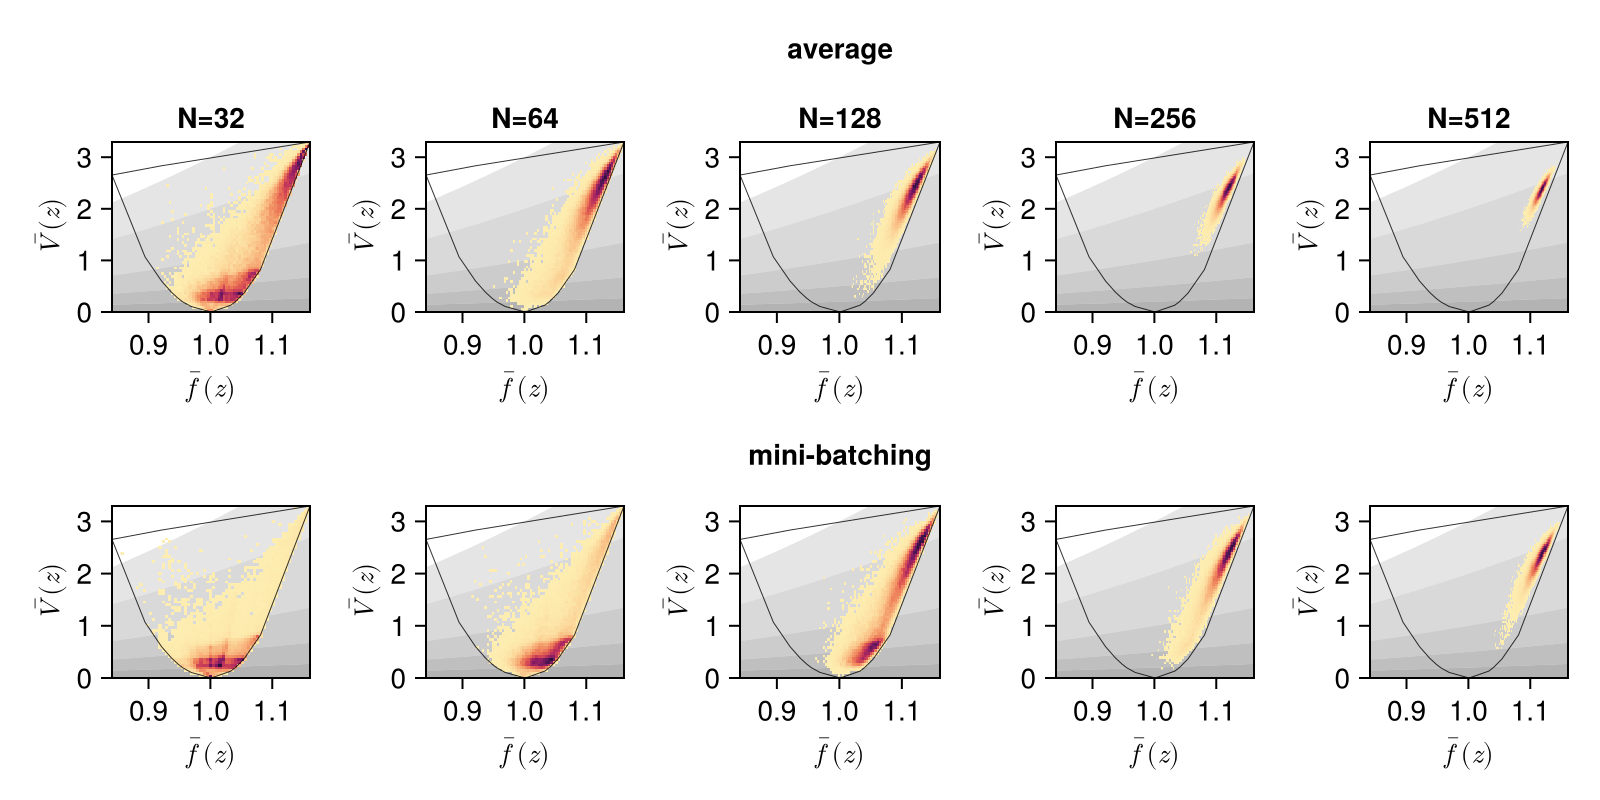

In [ ]:
f = Figure(size=(800,400))

Narr = 2 .^range(5,9)

H1 = [Axis(f[1,i],xlabel=L"\bar{f}(z)",ylabel=L"\bar{V}(z)",xgridvisible=false,ygridvisible=false) for i in 1:length(Narr)]
H2 = [Axis(f[3,i],xlabel=L"\bar{f}(z)",ylabel=L"\bar{V}(z)",xgridvisible=false,ygridvisible=false) for i in 1:length(Narr)]

colalpha=range(0.6,0.1,length=6)

Narr = 2 .^range(5,9)
i = 1
for N in Narr
    folder = pref*"N$(N)"*postf
    popX,popV = prf(folder,"saved_snaps",tini,nsteps,ncopies,dt,V);
    popX_ref,popV_ref = prf(folder,"saved_snaps_ref",tini,nsteps,ncopies,dt,V)
    x_mids, y_mids, counts = hist2d(popX,popV,nbins)

    j = 1
    a = 0
    for alpha in [0.2,0.5,1,2,3]
        band!(H1[i], x, a.*x.^2, alpha.*x.^2, color = :gray, alpha = colalpha[j])
        band!(H2[i], x, a.*x.^2, alpha.*x.^2, color = :gray, alpha = colalpha[j])
        a = copy(alpha)
        j += 1
    end

    hm2 = heatmap!(H2[i],x_mids,y_mids,counts,colormap=cgrad(:matter))

    x_mids, y_mids, counts = hist2d(popX_ref,popV_ref,nbins)
    hm1 = heatmap!(H1[i],x_mids,y_mids,counts,colormap=cgrad(:matter))

    lines!(H2[i],push!(C[1,:],C[1,1]),push!(C[2,:],C[2,1]),color=:black,alpha=0.8,linewidth=0.5)
    lines!(H1[i],push!(C[1,:],C[1,1]),push!(C[2,:],C[2,1]),color=:black,alpha=0.8,linewidth=0.5)

    H1[i].title = "N=$(N)"

    x = range(0.8,1.2,100)

    xlims!(H1[i],minimum(F),maximum(F))
    xlims!(H2[i],minimum(F),maximum(F))
    ylims!(H1[i],0,maximum(V))
    ylims!(H2[i],0,maximum(V))
    i+=1
end
titlelayout = GridLayout(f[0, :], halign = :center, tellwidth = false)
Label(titlelayout[1, 1], "average", halign = :center, font=:bold)

titlelayout = GridLayout(f[2, :], halign = :center, tellwidth = false)
Label(titlelayout[1, 1], "mini-batching", halign = :center, font=:bold)

save("compare_distrib_ext.pdf",f)
f

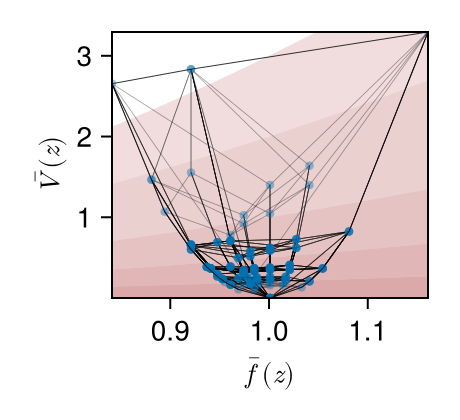

In [5]:
fig = Figure(size=(230,210))
ax = Axis(fig[1,1],xlabel=L"\bar{f}(z)",ylabel=L"\bar{V}(z)",xgridvisible=false,ygridvisible=false)

a = 0
x = range(0.8,1.2,100)
colalpha=range(0.4,0.1,length=6)
i = 1
for alpha in [0.2,0.5,1,2,3]
    band!(ax, x, a.*x.^2, alpha.*x.^2, color = :brown, alpha = colalpha[i])
    a = copy(alpha)
    i += 1
end
xlims!(ax,minimum(F),maximum(F))
ylims!(ax,minimum(V),maximum(V))

for spec in 0:2^L-1
    seq = digits(spec,base=2,pad=L)
    onehot = Matrix(I, L, L)
    neighs = [(seq .+ onehot[:,k]).%2 for k in 1:L]
    ngh = [bin_to_int(neighs[k]) for k in 1:L]
    for k in 1:L
        lines!(ax,[F[spec+1],F[ngh[k]+1]],[V[spec+1],V[ngh[k]+1]],linewidth=0.4,alpha=0.2,color=:black) 
    end
end

scatter!(ax,F,V,alpha=0.4,markersize=6)
t = map(F, V) do xi, yi
           [xi, yi]
    end;
ch = convex_hull(t)
C = reduce(hcat,ch)

lines!(ax,push!(C[1,:],C[1,1]),push!(C[2,:],C[2,1]),color=:black,alpha=0.8,linewidth=0.5)

save("shaded.pdf",fig)

fig